# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 

##Inspecting the data

any comment about data dimensionality/distribution goes here

#LIBRARY 

In [341]:

from keras import backend, Model
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dropout, Dense, LeakyReLU
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation
import os 
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import keras_metrics

from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.backend import abs, sum
import tensorflow as tf
from tensorflow.keras.utils import to_categorical





#import data 


In [342]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [343]:

X_train=pd.read_csv('/content/X_train.csv')
X_test=pd.read_csv('/content/X_test.csv')
y_train=pd.read_csv('/content/y_train.csv')

In [344]:
df = pd.merge(X_train, y_train, left_on = 'ID', right_on = 'ID')

df.rename(columns={'default.payment.next.month': 'PAY_NEXT_MONTH', 'PAY_0': 'PAY_1'}, inplace=True)
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_NEXT_MONTH
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,15010.821708,167226.653333,1.604917,1.854000,1.551417,35.494375,-0.016667,-0.131375,-0.168167,-0.220417,-0.265167,-0.288750,50927.468417,48914.770500,4.675708e+04,43013.532167,40150.333000,38763.540458,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125,0.221792
std,8680.406114,129734.959196,0.488879,0.792176,0.522766,9.235160,1.126473,1.197675,1.191685,1.168107,1.132949,1.152394,73400.840274,70923.493353,6.926506e+04,64069.494705,60635.882129,59281.986863,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219,0.415460
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7452.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3537.000000,2989.750000,2.699500e+03,2329.000000,1763.000000,1271.750000,1000.000000,8.615000e+02,390.000000,285.750000,240.750000,112.750000,0.000000
50%,15061.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22321.500000,21140.500000,2.005000e+04,19010.000000,18085.000000,17108.500000,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22509.250000,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66377.000000,63035.250000,5.952925e+04,53927.750000,50007.500000,49101.750000,5005.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4000.000000,0.000000
max,29999.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000,1.000000


 Creazione di un grafico a coppie di coefficienti di correlazione di tutte le caratteristiche al fine di identificare le caratteristiche degenerate

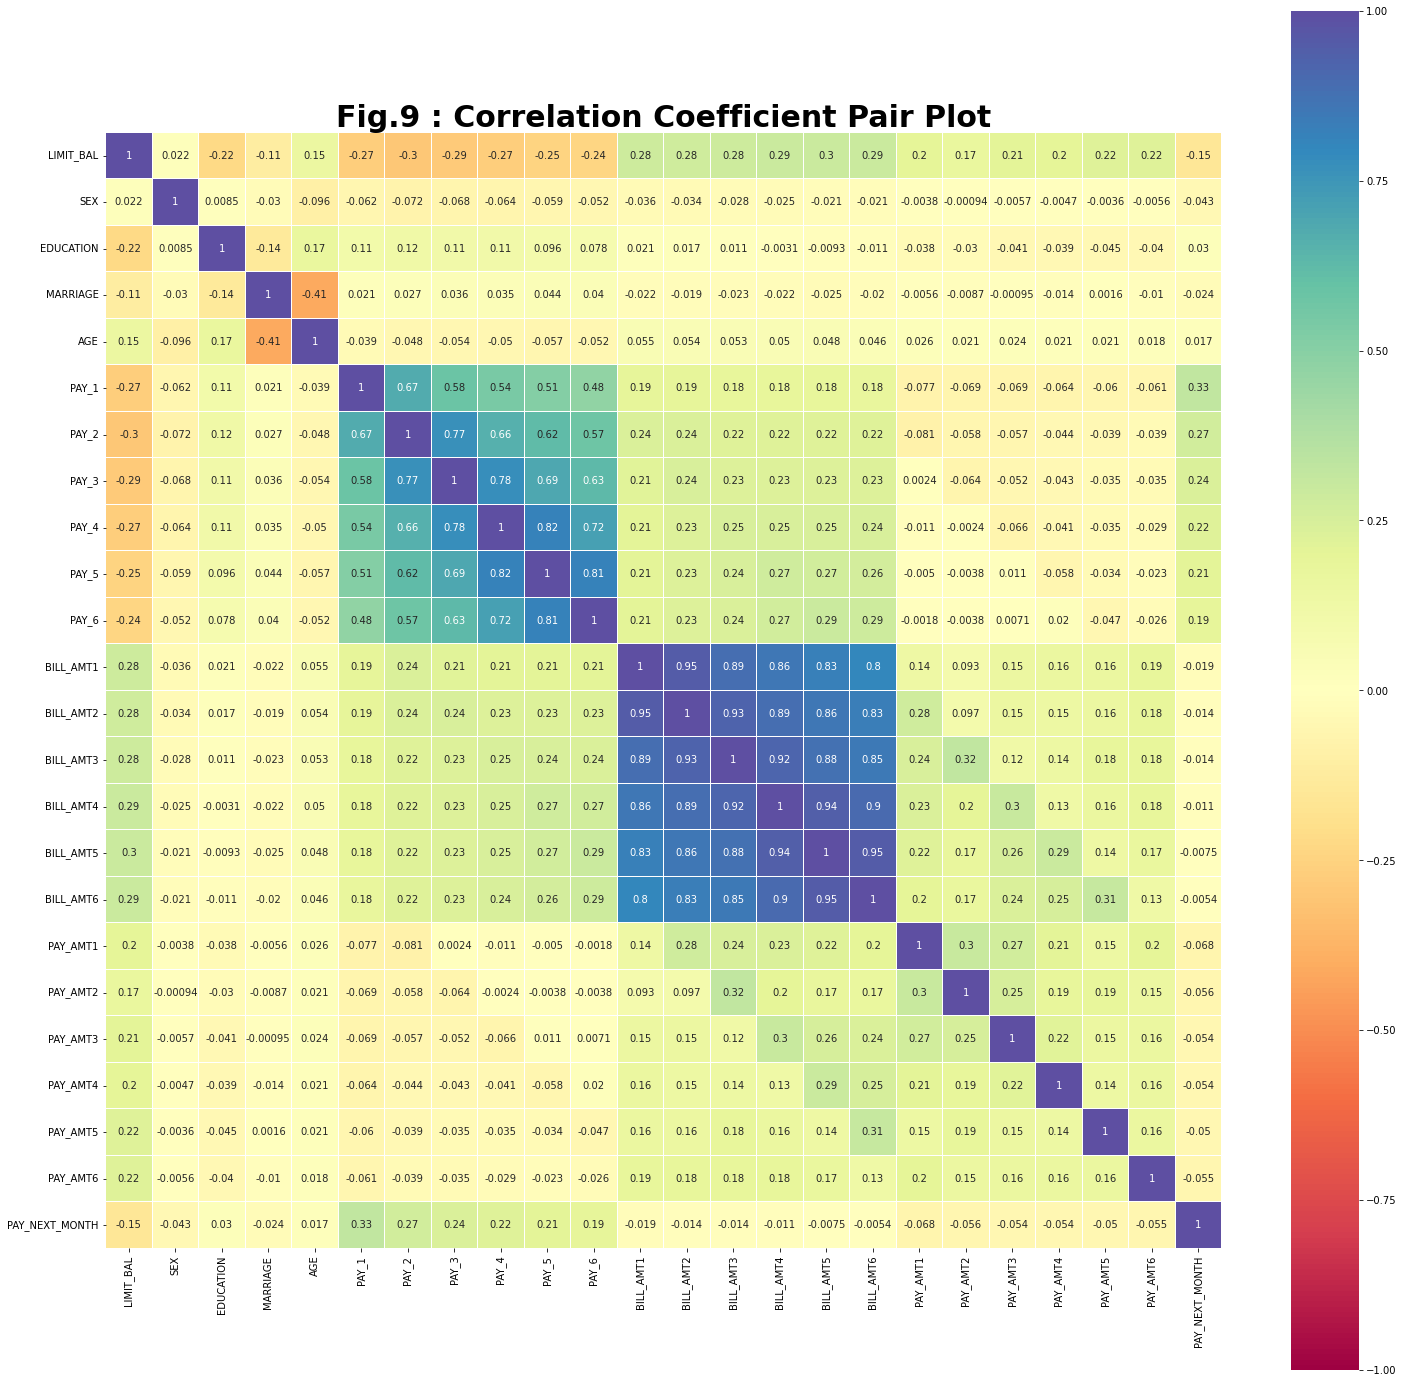

In [345]:

plt.figure(figsize=(25,25))
ax = plt.axes()
corr = df.drop(['ID'], axis=1).corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=True, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Fig.9 : Correlation Coefficient Pair Plot',fontweight="bold", size=30)
plt.show()

Il grafico mostra che  l'importo della fattura ('BILL_AMT') sono altamente correlate tra loro, hanno tuttavia un contributo minimo all'etichetta di destinazione ('default.payment.next.month'). Nel caso in cui la risorsa computazionale sia limitata, è possibile eliminare queste funzionalità senza perdere un significativo potere di previsione.

Anche le caratteristiche dello stato del pagamento ('PAY') sono correlate ma allo stesso tempo mostrano il contributo più elevato all'etichetta finale. L'ultima colonna mostra chiaramente che avvicinandosi al mese in corso aumenta il significativo dello stato di pagamento.

Anche la correlazione negativa tra "SEX" e "MARRIAGE" è interessante e potrebbe essere utilizzata per generare nuove funzionalità.

Evidenzio la distribuzione dei dati:

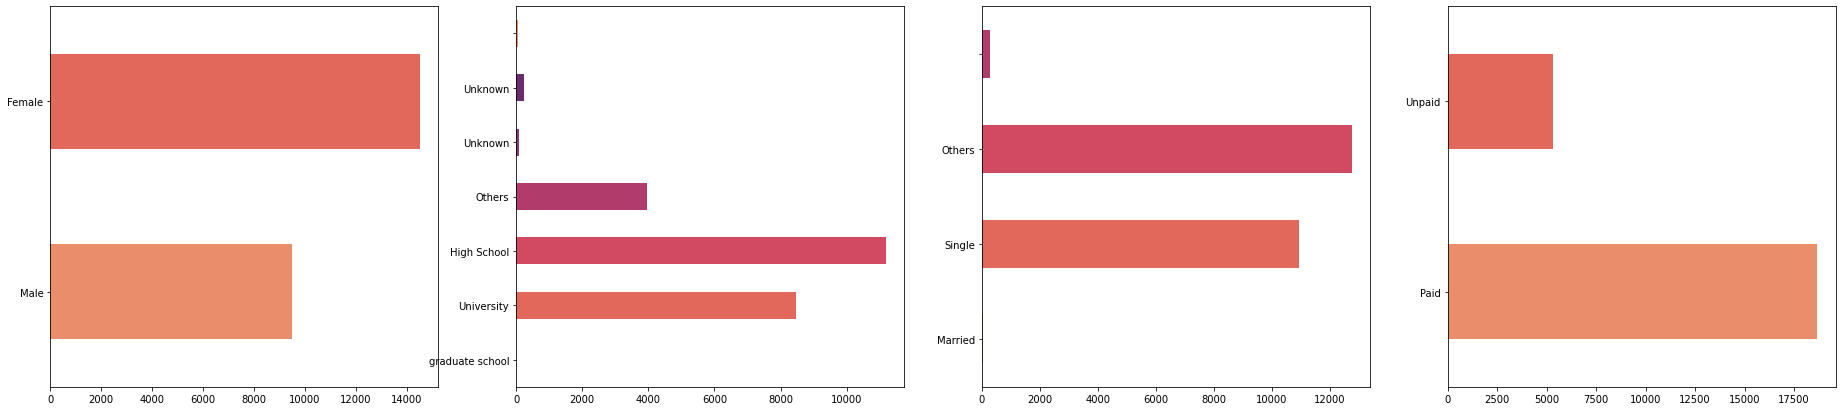

In [346]:
fig, axes = plt.subplots(1, 4, figsize=(32, 7))
bar_columns = {
    'SEX': ['Male', 'Female'],
    'EDUCATION': ['graduate school', 'University', 'High School', 'Others', 'Unknown','Unknown'],
    'MARRIAGE': [ 'Married', 'Single', 'Others'],
    'PAY_NEXT_MONTH': ['Paid', 'Unpaid']
}

colors = sns.color_palette("flare")
for i, (column, labels) in enumerate(bar_columns.items()):
    df[column].value_counts().sort_index().plot.barh(ax=axes[i], color=colors)
    axes[i].set_yticklabels(labels)

Calcolo la  diversa porzione di classe nel set di dati originale.

In [347]:
# Calculating default Ratio
non_default = len(df[df['PAY_NEXT_MONTH']==0])
default = len(df[df['PAY_NEXT_MONTH']==1])
ratio = float(default/(non_default+default))
print('Default Ratio :',ratio)

Default Ratio : 0.22179166666666666


Qui è evidente che la classe di default compare solo nel 22%, il che si traduce in dati di squilibrio. Questo problema potrebbe  essere risolto imponendo una perdita di peso proporzionale durante l'adattamento del modello.

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

In [348]:
X_train = df.drop(['PAY_NEXT_MONTH'], axis=1)
X_train = StandardScaler().fit_transform(X_train)

y_train = (df['PAY_NEXT_MONTH']).values.reshape(-1,1)

Trasformo in array:

In [349]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [350]:
print(X_train.shape)
X_train

(24000, 24)


array([[ 0.7768437 , -0.67235905,  0.8081586 , ..., -0.2246542 ,
        -0.2160079 , -0.24524018],
       [-1.7002809 , -1.0577682 , -1.237381  , ..., -0.24078482,
        -0.30852285, -0.29553163],
       [ 0.9137065 ,  0.0984593 ,  0.8081586 , ...,  0.12267581,
         0.3534871 , -0.28510675],
       ...,
       [-1.6301215 , -0.9036045 , -1.237381  , ..., -0.29935804,
        -0.30852285, -0.29553163],
       [ 0.09045598, -0.74944085,  0.8081586 , ..., -0.2257582 ,
        -0.30852285, -0.22679618],
       [ 0.9958472 , -0.05570437,  0.8081586 , ..., -0.19815825,
         0.60062045, -0.20961231]], dtype=float32)

In [351]:
print(y_train.shape)
y_train


(24000, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [352]:
print(X_test.shape)
X_test

(6000, 24)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2309.0,30000.0,1.0,2.0,2.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,8864.0,10062.0,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
1,22405.0,150000.0,2.0,1.0,2.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,136736.0,125651.0,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
2,23398.0,70000.0,2.0,3.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,70122.0,69080.0,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
3,25059.0,130000.0,1.0,3.0,2.0,49.0,0.0,0.0,0.0,0.0,0.0,-1.0,20678.0,18956.0,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
4,2665.0,50000.0,2.0,2.0,2.0,36.0,0.0,0.0,0.0,0.0,0.0,2.0,94228.0,47635.0,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2211.0,360000.0,2.0,1.0,2.0,27.0,1.0,-2.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,830.0,0.0,1271.0,179.0,0.0,830.0,0.0,1271.0,179.0,1970.0
5996,14145.0,500000.0,2.0,1.0,2.0,28.0,2.0,0.0,0.0,2.0,0.0,0.0,98541.0,102052.0,111690.0,78070.0,78376.0,80912.0,6000.0,13151.0,0.0,3000.0,5000.0,10000.0
5997,23109.0,60000.0,2.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,2.0,46233.0,47263.0,48696.0,50385.0,52045.0,52661.0,2100.0,2500.0,2500.0,2500.0,1600.0,1500.0
5998,25704.0,20000.0,2.0,1.0,2.0,29.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,2494.0,3967.0,1364.0,600.0,0.0,2494.0,3967.0,1370.0,600.0,0.0,0.0


In [353]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

predictors = df.drop(['PAY_NEXT_MONTH'], axis=1)
predictors = StandardScaler().fit_transform(predictors)

target = to_categorical(df['PAY_NEXT_MONTH']) 

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

Ho diviso per  80% del training set e 20% sul test set per creare un set di convalida. La struttura del modello è:

In [354]:
X_train, X_validation, y_train, Y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [355]:

print('Train dims', X_train.shape)
print('Test dims', X_test.shape)
print('Target dims', y_train.shape)

Train dims (19200, 24)
Test dims (6000, 24)
Target dims (19200, 1)


In [356]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


**Costruisco il modello**:

Ho provato diverse combinazioni e stabilito 3 livelli nascosti composti da 32, 16, 8  unità, il livello di input contiene unità quante sono le etichette del trainingset e il livello di output contiene solo una unità come il nostro obiettivo. Ho provato ad aumentare il numero dei livelli nascosti ma il risultato è stato peggiore. 


**Funzione di attivazione**: scelgo la funzione ReLU che è adatta per questo modello e in generale è una buona scelta per i livelli nascosti.

**Optimizer:** scelgo Adam perché determina prestazioni migliori.

**Perdita:** ho provato diverse funzioni di perdita come mae, mse ma l'attività di classificazione binaria ha raggiunto prestazioni migliori, quindi ho scelto questo.

**Metriche:** ho misurato le peformance del modello attraverso accurancy, precision e recall.

**Funzione di output:** la classe è booleano [0,1], quindi ho provato con softmax, ma le prestazioni erano molto scarse, quindi ho scelto la funzione sigmoide che è adatta per  questo modello.

In [357]:
dims = X_train.shape[1]

#"advanced" usage -- a possible way to initialize weights ..> https://keras.io/api/layers/initializers/
initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

# BUILD
model = Sequential()
model.add(Dense(32, input_shape=(dims,), activation = "relu", kernel_initializer=initializer))
model.add(Dense(16, activation = "relu", kernel_initializer=initializer))
model.add(Dense(8, activation = "relu", kernel_initializer=initializer))
model.add(Dense(1, activation = "sigmoid", kernel_initializer=initializer))


# COMPILE --> optimization details

from tensorflow.keras.optimizers import SGD,Adam # yet another way to set up optimizers explicitly --> https://keras.io/api/optimizers/
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [358]:
# We already used `summary`
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_221 (Dense)            (None, 32)                800       
_________________________________________________________________
dense_222 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_223 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [359]:
print('Xval dims', X_validation.shape)
print('Yval dims', Y_validation.shape)

Xval dims (4800, 24)
Yval dims (4800, 1)


#Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?





Ho effetuato diverse prove per bilanciare il numero di epoche con il batchsize e vedo che oltre 90 epoche l'accurancy del modello non aumenta e la funzione di perdita non diminuisce troppo. Per il batch size ho provato diverse dimensioni (32,64,128,256,512), miglior performance  con 128. Questi sono i risultati del modello senza regolarizzazione:

In [360]:
#train! --> notice the validation steps

n_epochs =90
network_history = model.fit(X_train, y_train, batch_size=128, 
                            epochs=n_epochs, verbose=2, validation_data=(X_validation, Y_validation))

Epoch 1/90
150/150 - 2s - loss: 0.7506 - accuracy: 0.3912 - f1_m: 0.3610 - precision_m: 0.2379 - recall_m: 0.7821 - val_loss: 0.6844 - val_accuracy: 0.5221 - val_f1_m: 0.3474 - val_precision_m: 0.2513 - val_recall_m: 0.5773
Epoch 2/90
150/150 - 0s - loss: 0.6312 - accuracy: 0.6881 - f1_m: 0.3486 - precision_m: 0.3509 - recall_m: 0.3841 - val_loss: 0.5897 - val_accuracy: 0.7590 - val_f1_m: 0.2872 - val_precision_m: 0.4233 - val_recall_m: 0.2217
Epoch 3/90
150/150 - 0s - loss: 0.5625 - accuracy: 0.7845 - f1_m: 0.2780 - precision_m: 0.5527 - recall_m: 0.1944 - val_loss: 0.5393 - val_accuracy: 0.7842 - val_f1_m: 0.2081 - val_precision_m: 0.5609 - val_recall_m: 0.1309
Epoch 4/90
150/150 - 0s - loss: 0.5290 - accuracy: 0.7928 - f1_m: 0.2438 - precision_m: 0.6418 - recall_m: 0.1542 - val_loss: 0.5162 - val_accuracy: 0.7900 - val_f1_m: 0.2109 - val_precision_m: 0.6437 - val_recall_m: 0.1296
Epoch 5/90
150/150 - 0s - loss: 0.5121 - accuracy: 0.7957 - f1_m: 0.2600 - precision_m: 0.6540 - recall_

Il risultato mostra i seguenti valori:

*   accurancy 82%
*   precision 69%
*   recall 37%

Il modello protrebbe migliorare applicando una regolarizzazione.





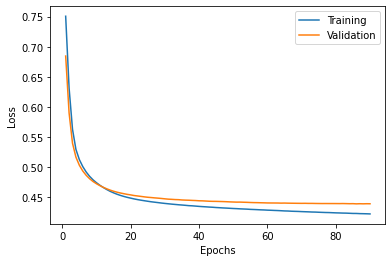

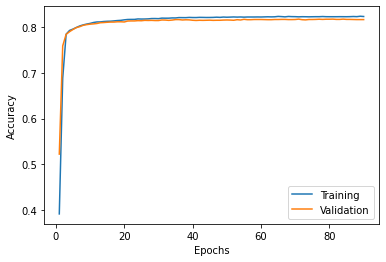

In [361]:
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

Dal grafico si evidenzia: la perdita diminuisce e la precisione molto simile tra training e validation, non molto overfitting.

## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [362]:
# generate predictions for training
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
print(trainPredict)
print(testPredict)

[[0.666694  ]
 [0.09269932]
 [0.22579935]
 ...
 [0.6985119 ]
 [0.693014  ]
 [0.04237944]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [364]:
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)
predictions[:10]

predictions shape: (6000, 1)


array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

# OPTIONAL -- Export the predictions in the format indicated in the assignment release page.

# OPTIONAL -- Implement some regularization methods of your choice and make a comparison between (training/validation) performances of regularized models (also compare with the case of no regularization)

Attempts in this section will be taken into account, if well-enough done, to (at least partially) compensate for potential incorrectessness in the mandatory sections. 
On the other hand, any incorrectessness in _this_ section won't be taken into account in the final score.

#Regolarizzazione L1

In [365]:

def NeuralNetwork_l1():
  dims = X_train.shape[1]
  model_l1 = Sequential()
  model_l1.add(Dense(256, input_shape=(dims,), activation = "relu",kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
  model_l1.add(Dense(128, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
  model_l1.add(Dense(32, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
  model_l1.add(Dense(16, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
  model_l1.add(Dense(1, activation = "sigmoid", kernel_initializer=initializer))        


  model_l1.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])

  
  return model_l1

In [366]:
model_l1 = NeuralNetwork_l1()
model_l1.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 256)               6400      
_________________________________________________________________
dense_226 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_227 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_228 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 17        
Total params: 43,969
Trainable params: 43,969
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [367]:

network_history_l1 = model_l1.fit(X_train, y_train, batch_size=128, 
                              epochs=90, verbose=2, validation_data=(X_validation, Y_validation))

Epoch 1/90
150/150 - 1s - loss: 30.2018 - accuracy: 0.3064 - val_loss: 29.8279 - val_accuracy: 0.5171
Epoch 2/90
150/150 - 0s - loss: 29.4811 - accuracy: 0.7001 - val_loss: 29.1385 - val_accuracy: 0.7744
Epoch 3/90
150/150 - 1s - loss: 28.8071 - accuracy: 0.7826 - val_loss: 28.4770 - val_accuracy: 0.7798
Epoch 4/90
150/150 - 1s - loss: 28.1544 - accuracy: 0.7821 - val_loss: 27.8318 - val_accuracy: 0.7767
Epoch 5/90
150/150 - 1s - loss: 27.5156 - accuracy: 0.7807 - val_loss: 27.1990 - val_accuracy: 0.7771
Epoch 6/90
150/150 - 1s - loss: 26.8880 - accuracy: 0.7802 - val_loss: 26.5764 - val_accuracy: 0.7767
Epoch 7/90
150/150 - 0s - loss: 26.2699 - accuracy: 0.7797 - val_loss: 25.9628 - val_accuracy: 0.7763
Epoch 8/90
150/150 - 0s - loss: 25.6609 - accuracy: 0.7795 - val_loss: 25.3586 - val_accuracy: 0.7763
Epoch 9/90
150/150 - 0s - loss: 25.0610 - accuracy: 0.7796 - val_loss: 24.7632 - val_accuracy: 0.7763
Epoch 10/90
150/150 - 0s - loss: 24.4698 - accuracy: 0.7797 - val_loss: 24.1762 - 

#Regolarizzazione L2

In [368]:
model_l2 = Sequential()
model_l2.add(Dense(512, input_shape=(dims,), activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(256, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(32, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(16, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(1, activation = "sigmoid"))

model_l2.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])
model_l2.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.001), 
              metrics=['accuracy'])
model_l2.fit(X_train, y_train, batch_size=128, 
                            epochs=20, verbose=2, validation_data=(X_validation, Y_validation))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
150/150 - 2s - loss: 5.3002 - accuracy: 0.7490 - val_loss: 5.2698 - val_accuracy: 0.7754
Epoch 2/20
150/150 - 1s - loss: 5.2428 - accuracy: 0.7788 - val_loss: 5.2162 - val_accuracy: 0.7760
Epoch 3/20
150/150 - 1s - loss: 5.1915 - accuracy: 0.7788 - val_loss: 5.1674 - val_accuracy: 0.7760
Epoch 4/20
150/150 - 1s - loss: 5.1450 - accuracy: 0.7788 - val_loss: 5.1230 - val_accuracy: 0.7760
Epoch 5/20
150/150 - 1s - loss: 5.1026 - accuracy: 0.7788 - val_loss: 5.0825 - val_accuracy: 0.7760
Epoch 6/20
150/150 - 1s - loss: 5.0636 - accuracy: 0.7788 - val_loss: 5.0450 - val_accuracy: 0.7760
Epoch 7/20
150/150 - 1s - loss: 5.0273 - accuracy: 0.7788 - val_loss: 5.0097 - val_accuracy: 0.7760
Epoch 8/20
150/150 - 1s - loss: 4.9929 - accuracy: 0.7788 - val_loss: 4.9762 - val_accuracy: 0.7760
Epoch 9/20
150/150 - 1s - loss: 4.9600 - accuracy: 0.7788 - val_loss: 4.9440 - val_accuracy: 0.7760
Epoch 10/20
150/150 - 1s - loss: 4.9284 - accuracy: 0.7788 - val_loss: 4.9130 - val_accuracy: 0.7760

Si denota come L2 sia migliore come modello rispetto a L1.

I valori sono:

*   accurancy L1 0.78
*   accurancy L2 0.79


In [369]:
# Deep Learning Libraries
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import class_weight
from keras.layers.core import Dense, Dropout

#Weight Control

Analizzo come sono cambiati i pesi introducendo le penalità nel modello

In [370]:
print('Layers name:', model_l2.weights[6].name)
print('Layers kernel shape:', model_l2.weights[6].shape)
print('Kernel:', model_l2.weights[6][0], end = '\n\n')
print('Layers name:', model_l2.weights[7].name)
print('Layers kernel shape:', model_l2.weights[7].shape)
print('Kernel:', model_l2.weights[7])

Layers name: dense_233/kernel:0
Layers kernel shape: (32, 16)
Kernel: tf.Tensor(
[ 0.162948    0.34071147 -0.19736515  0.21608329 -0.06889825 -0.18958151
  0.00244595  0.34508032  0.30390412 -0.18844922 -0.02170725  0.05426548
 -0.13487017  0.22808973 -0.05250969 -0.15299055], shape=(16,), dtype=float32)

Layers name: dense_233/bias:0
Layers kernel shape: (16,)
Kernel: <tf.Variable 'dense_233/bias:0' shape=(16,) dtype=float32, numpy=
array([ 6.2092878e-03,  9.3574278e-02,  2.6362955e-03,  8.4022418e-02,
       -5.5568162e-02,  1.0270488e-02,  8.1905387e-02,  7.3558025e-02,
       -5.1451169e-02,  3.3705906e-05, -2.1640198e-02,  2.4586897e-02,
       -1.3076909e-02,  7.2377861e-02,  1.2614785e-02,  2.4657659e-04],
      dtype=float32)>


In [371]:
print('Layers name:', model_l1.weights[6].name)
print('Layers kernel shape:', model_l1.weights[6].shape)
print('Kernel:', model_l1.weights[6][0], end = '\n\n')
print('Layers name:', model_l1.weights[7].name)
print('Layers kernel shape:', model_l1.weights[7].shape)
print('Kernel:', model_l1.weights[7])

Layers name: dense_228/kernel:0
Layers kernel shape: (32, 16)
Kernel: tf.Tensor(
[ 4.0285341e-02  2.0738961e-01 -7.4491188e-02  7.3329255e-02
  5.0546810e-06 -7.8241646e-02  9.1739576e-06  2.0958751e-01
  2.1259740e-01 -6.5045014e-02 -5.4432749e-06  4.3621494e-06
 -1.1600088e-02  9.0385713e-02  6.5918766e-06 -3.3073626e-02], shape=(16,), dtype=float32)

Layers name: dense_228/bias:0
Layers kernel shape: (16,)
Kernel: <tf.Variable 'dense_228/bias:0' shape=(16,) dtype=float32, numpy=
array([-1.6368779e-03, -2.6761396e-02,  3.3540566e-02,  1.7163536e-02,
        8.0389090e-02,  2.8157908e-01,  7.1362208e-04, -2.9450466e-03,
       -1.0480913e-02, -9.9296522e-05,  4.1361112e-02,  1.7118668e-02,
        2.1357486e-01,  8.6677950e-03,  6.4398989e-02,  1.4693569e-01],
      dtype=float32)>


In [372]:

print('Sum of the values of the weights with regularization l2:', sum(abs(model_l2.weights[6][0])).numpy() + sum(abs(model_l2.weights[7][0])).numpy())
print('Sum of the values of the weights with regularization l1:', sum(abs(model_l1.weights[6][0])).numpy() + sum(abs(model_l1.weights[7][0])).numpy())

Sum of the values of the weights with regularization l2: 2.6661096
Sum of the values of the weights with regularization l1: 1.0976938


#DROPOUT

In [373]:
initializer = tf.keras.initializers.GlorotUniform(seed=1234)

model_d = Sequential()
model_d.add(Dense(256, input_shape=(dims,), activation = "relu", kernel_initializer=initializer))
model_d.add(Dense(128, activation = "relu", kernel_initializer=initializer))
model_d.add(Dropout(0.2))
model_d.add(Dense(32, activation = "relu", kernel_initializer=initializer))
model_d.add(Dropout(0.2))
model_d.add(Dense(16, activation = "relu", kernel_initializer=initializer))
model_d.add(Dropout(0.2))
model_d.add(Dense(1, activation = "sigmoid", kernel_initializer=initializer))


model_d.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])
model_d.fit(X_train, y_train, batch_size=128, 
                            epochs=20, verbose=2, validation_data=(X_validation, Y_validation))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
150/150 - 1s - loss: 0.7671 - accuracy: 0.3473 - val_loss: 0.6986 - val_accuracy: 0.5090
Epoch 2/20
150/150 - 1s - loss: 0.6880 - accuracy: 0.5878 - val_loss: 0.6512 - val_accuracy: 0.7708
Epoch 3/20
150/150 - 1s - loss: 0.6474 - accuracy: 0.7218 - val_loss: 0.6218 - val_accuracy: 0.7758
Epoch 4/20
150/150 - 0s - loss: 0.6198 - accuracy: 0.7653 - val_loss: 0.6000 - val_accuracy: 0.7771
Epoch 5/20
150/150 - 1s - loss: 0.5984 - accuracy: 0.7755 - val_loss: 0.5826 - val_accuracy: 0.7763
Epoch 6/20
150/150 - 0s - loss: 0.5833 - accuracy: 0.7798 - val_loss: 0.5684 - val_accuracy: 0.7760
Epoch 7/20
150/150 - 1s - loss: 0.5696 - accuracy: 0.7821 - val_loss: 0.5568 - val_accuracy: 0.7760
Epoch 8/20
150/150 - 0s - loss: 0.5605 - accuracy: 0.7811 - val_loss: 0.5471 - val_accuracy: 0.7760
Epoch 9/20
150/150 - 1s - loss: 0.5531 - accuracy: 0.7814 - val_loss: 0.5391 - val_accuracy: 0.7760
Epoch 10/20
150/150 - 1s - loss: 0.5447 - accuracy: 0.7815 - val_loss: 0.5323 - val_accuracy: 0.7763

Vediamo che il modello  ha una performance migliore.